# **Data Analysis and Feature Engineering for Delivery Dataset**

## **1. Analytical Question**
To drive a meaningful investigation, I define the following analytical question:

> **"What are the key factors influencing delivery time, and how can I predict delivery efficiency based on delivery personnel characteristics, weather conditions, and traffic levels?"**

This question will help guide my analysis toward uncovering the most influential variables affecting delivery times, ultimately aiding in building a predictive model for delivery time estimation.


## **2. Feature Engineering**
To enhance predictive power, I introduce **six new features** while ensuring they do not cause target leakage.

### **1. Traffic Density Score**
**Formula:**  
$ \text{Traffic Density Score} = \text{Traffic Level} \times \text{Distance (km)} $

- **Why?** This feature measures the expected congestion effect on delivery times, as longer distances in high-traffic conditions are likely to take more time.


### **2. Weather Impact Score**
**Formula:**  
$ \text{Weather Impact Score} = \text{humidity} + \text{precipitation} + \text{weather description} $

- **Why?** Combines multiple weather factors into a single numerical value to understand how environmental conditions affect delivery time.


### **3. Experience-Adjusted Ratings**
**Formula:**  
$ \text{Experience Score} = \text{Delivery Person Age} \times \text{Delivery Person Ratings} $

- **Why?** Assesses whether more experienced delivery personnel tend to receive higher ratings and if this correlates with better efficiency.


### **4. Weather Severity Indicator**
**Formula:**  
$ \text{Weather Severity} = \frac{\text{humidity} + \text{precipitation}}{2} $

- **Why?** Averages humidity and precipitation to create a simplified weather severity index, indicating potential delivery delays.

Here’s **Point 5: Haversine Distance** formatted properly for Jupyter Notebook and Markdown without using LaTeX dollar signs to avoid rendering issues:


### **5. Haversine Distance**

**Formula:**
Haversine Distance is calculated using the following formula:

```
Haversine Distance = 2 * R * arcsin( sqrt( sin²(Δφ / 2) + cos(φ₁) * cos(φ₂) * sin²(Δλ / 2) ) )
```

Where:
- **R** = Earth's radius (≈ 6371 km)
- **φ₁, φ₂** = Latitudes (in radians) of the restaurant and delivery location
- **λ₁, λ₂** = Longitudes (in radians) of the restaurant and delivery location
- **Δφ = φ₂ - φ₁**
- **Δλ = λ₂ - λ₁**

**Why?**  
Haversine distance calculates the great-circle distance between the restaurant and delivery location. This provides a more accurate measurement of actual geographic distance rather than just Euclidean or road-based distances.



This structured approach ensures that my dataset is well-prepared for predictive modeling and insightful analysis while avoiding target leakage.


In [1]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'msds610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'Harideep' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'raw' # schema we just created

In [2]:
from sqlalchemy import create_engine

# create a connection to the database
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')
connection = engine.connect()

In [3]:
# Using Raw Data and performing same Data processing like in week 3. Because in last week assignment 
# I did data normalization because which I cannot extract thesse new features

# Pulling the data from the delivery_data table
import pandas as pd
query = 'SELECT * FROM raw.delivery_data;'
delivery_data = pd.read_sql_query(query, connection)
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Unnamed: 14,Traffic_Level,Distance (km),TARGET
0,4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,17.11,77.0,0.0,haze,None,Low,NaN,21.66666667
1,B379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,19.50,93.0,0.0,mist,None,Very High,37.17,85.26666667
2,5D6D,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,20.45,91.0,0.0,mist,None,Low,3.34,28.58333333
3,7A6A,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,23.86,78.0,0.0,mist,None,Moderate,10.05,35.18333333
4,70A2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,26.55,87.0,0.0,mist,None,High,9.89,43.45


In [4]:
# Dropping the missing values abd column Unnamed: 14
delivery_data.drop(columns=['Unnamed: 14'], inplace=True)
delivery_data.dropna(inplace=True)
delivery_data.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
temperature                    0
humidity                       0
precipitation                  0
weather_description            0
Traffic_Level                  0
Distance (km)                  0
TARGET                         0
dtype: int64

In [5]:
# Catagozing the traffic level to numerical values
traffic_level = {'Very High': 4, 'High': 3, 'Moderate': 2, 'Low': 1, 'Very Low': 0}
weather_description = delivery_data.weather_description.unique()
Type_of_order = delivery_data.Type_of_order.unique()
Type_of_vehicle = delivery_data.Type_of_vehicle.unique()

# Create a dictionary for the weather_description, Type_of_order and Type_of_vehicle with numerical values
weather_description_dict = {weather_description[i]: i for i in range(len(weather_description))}
Type_of_order_dict = {Type_of_order[i]: i for i in range(len(Type_of_order))}
Type_of_vehicle_dict = {Type_of_vehicle[i]: i for i in range(len(Type_of_vehicle))}

In [6]:
# Converting the weather_description, Type_of_order and Type_of_vehicle to numerical values
delivery_data['Traffic_Level'] = delivery_data['Traffic_Level'].map(traffic_level)
delivery_data['weather_description'] = delivery_data['weather_description'].map(weather_description_dict)
delivery_data['Type_of_order'] = delivery_data['Type_of_order'].map(Type_of_order_dict)
delivery_data['Type_of_vehicle'] = delivery_data['Type_of_vehicle'].map(Type_of_vehicle_dict)

In [7]:
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET
1,B379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667
2,5D6D,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333
3,7A6A,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333
4,70A2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,26.55,87.0,0.0,0,3,9.89,43.45
5,9BB4,HYDRES09DEL03,22.0,4.8,17.431668,78.408321,17.461668,78.438321,2,1,21.43,65.0,0.0,1,2,11.30,30.6


In [8]:
# Parameter Extraction Haversine Distance: The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):

    # Radius of the Earth in km
    R = 6371.0

    # Converting latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Calculating the change in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2

    return a

In [9]:
delivery_data['haversine_distance'] = haversine_distance(delivery_data['Restaurant_latitude'], 
                                                         delivery_data['Restaurant_longitude'], 
                                                         delivery_data['Delivery_location_latitude'], 
                                                         delivery_data['Delivery_location_longitude'])

In [10]:
# Dropping the columns that are not needed
delivery_data.drop(columns=['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Delivery_person_ID'], inplace=True)

In [11]:
delivery_data.head()

,ID,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET,haversine_distance
1,B379,34.0,4.5,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667,2.509104e-06
2,5D6D,23.0,4.4,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333,1.485020e-08
3,7A6A,38.0,4.7,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333,3.738044e-07
4,70A2,32.0,4.6,0,0,26.55,87.0,0.0,0,3,9.89,43.45,2.375348e-07
5,9BB4,22.0,4.8,2,1,21.43,65.0,0.0,1,2,11.30,30.6,1.309168e-07


In [12]:
# 1. Traffic Density Score = Traffic Level * Distance (km)
delivery_data['Traffic_Density_Score'] = delivery_data['Traffic_Level'] * delivery_data['Distance (km)']

# 2. Weather Impact Score = humidity + precipitation + weather description
delivery_data['Weather_Impact_Score'] = delivery_data['humidity'] + delivery_data['precipitation'] + delivery_data['weather_description']

In [13]:
# 3. Experience-Adjusted Ratings = Delivery Person Age * Delivery Person Ratings
delivery_data['Experience_Adjusted_Ratings'] = delivery_data['Delivery_person_Age'] * delivery_data['Delivery_person_Ratings']

In [14]:
# 5. Location-Based Delivery Time Estimation:
# Bin 'Distance (km)' into intervals (e.g., 0-1 km, 1-2 km, 2-4 km, and 4+ km)
bins = [0, 1, 2, 4, np.inf]
labels = ['0-1', '1-2', '2-4', '4+']
delivery_data['Distance_bin'] = pd.cut(delivery_data['Distance (km)'], bins=bins, labels=labels, include_lowest=True)

# 6. Weather Severity Indicator = (humidity + precipitation) / 2
delivery_data['Weather_Severity'] = (delivery_data['humidity'] + delivery_data['precipitation']) / 2

In [15]:
delivery_data.head()

,ID,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET,haversine_distance,Traffic_Density_Score,Weather_Impact_Score,Experience_Adjusted_Ratings,Distance_bin,Weather_Severity
1,B379,34.0,4.5,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667,2.509104e-06,148.68,93.0,153.0,4+,46.5
2,5D6D,23.0,4.4,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333,1.485020e-08,3.34,91.0,101.2,2-4,45.5
3,7A6A,38.0,4.7,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333,3.738044e-07,20.10,78.0,178.6,4+,39.0
4,70A2,32.0,4.6,0,0,26.55,87.0,0.0,0,3,9.89,43.45,2.375348e-07,29.67,87.0,147.2,4+,43.5
5,9BB4,22.0,4.8,2,1,21.43,65.0,0.0,1,2,11.30,30.6,1.309168e-07,22.60,66.0,105.6,4+,32.5


In [16]:
# Label Encoding for Distance_bin
delivery_data['Distance_bin'] = delivery_data['Distance_bin'].map({'0-1': 0, '1-2': 1, '2-4': 2, '4+': 3})
delivery_data.head()

,ID,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET,haversine_distance,Traffic_Density_Score,Weather_Impact_Score,Experience_Adjusted_Ratings,Distance_bin,Weather_Severity
1,B379,34.0,4.5,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667,2.509104e-06,148.68,93.0,153.0,3,46.5
2,5D6D,23.0,4.4,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333,1.485020e-08,3.34,91.0,101.2,2,45.5
3,7A6A,38.0,4.7,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333,3.738044e-07,20.10,78.0,178.6,3,39.0
4,70A2,32.0,4.6,0,0,26.55,87.0,0.0,0,3,9.89,43.45,2.375348e-07,29.67,87.0,147.2,3,43.5
5,9BB4,22.0,4.8,2,1,21.43,65.0,0.0,1,2,11.30,30.6,1.309168e-07,22.60,66.0,105.6,3,32.5


# Week 6 Assignment

In [17]:
delivery_data.columns

Index(['ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Type_of_order',
       'Type_of_vehicle', 'temperature', 'humidity', 'precipitation',
       'weather_description', 'Traffic_Level', 'Distance (km)', 'TARGET',
       'haversine_distance', 'Traffic_Density_Score', 'Weather_Impact_Score',
       'Experience_Adjusted_Ratings', 'Distance_bin', 'Weather_Severity'],
      dtype='object')

In [18]:
# Data Encoding
from sklearn.model_selection import train_test_split

delivery_data_encoded = pd.get_dummies(delivery_data, columns=['Type_of_order', 'Type_of_vehicle', 'weather_description', 'Traffic_Level'], drop_first=True, dtype=int)

delivery_data_encoded


,ID,Delivery_person_Age,Delivery_person_Ratings,temperature,humidity,precipitation,Distance (km),TARGET,haversine_distance,Traffic_Density_Score,...,weather_description_4,weather_description_5,weather_description_6,weather_description_7,weather_description_8,weather_description_9,Traffic_Level_1,Traffic_Level_2,Traffic_Level_3,Traffic_Level_4
1,B379,34.0,4.5,19.50,93.0,0.0,37.17,85.26666667,2.509104e-06,148.68,...,0,0,0,0,0,0,0,0,0,1
2,5D6D,23.0,4.4,20.45,91.0,0.0,3.34,28.58333333,1.485020e-08,3.34,...,0,0,0,0,0,0,1,0,0,0
3,7A6A,38.0,4.7,23.86,78.0,0.0,10.05,35.18333333,3.738044e-07,20.10,...,0,0,0,0,0,0,0,1,0,0
4,70A2,32.0,4.6,26.55,87.0,0.0,9.89,43.45,2.375348e-07,29.67,...,0,0,0,0,0,0,0,0,1,0
5,9BB4,22.0,4.8,21.43,65.0,0.0,11.30,30.6,1.309168e-07,22.60,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4347,25.0,4.0,28.03,57.0,0.0,3.78,18.2,1.441577e-08,3.78,...,0,0,1,0,0,0,1,0,0,0
9996,11B4,32.0,4.2,23.96,64.0,0.0,18.92,32.61666667,1.144464e-06,56.76,...,0,1,0,0,0,0,0,0,1,0
9997,8336,36.0,4.7,22.94,60.0,0.0,2.64,12.01666667,1.454315e-08,2.64,...,0,1,0,0,0,0,1,0,0,0
9998,338B,37.0,4.6,23.72,31.0,0.0,28.80,51.06666667,2.677943e-06,115.20,...,0,0,0,0,0,0,0,0,0,1


In [19]:
delivery_data_encoded.columns

Index(['ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'temperature',
       'humidity', 'precipitation', 'Distance (km)', 'TARGET',
       'haversine_distance', 'Traffic_Density_Score', 'Weather_Impact_Score',
       'Experience_Adjusted_Ratings', 'Distance_bin', 'Weather_Severity',
       'Type_of_order_1', 'Type_of_order_2', 'Type_of_order_3',
       'Type_of_vehicle_1', 'Type_of_vehicle_2', 'Type_of_vehicle_3',
       'weather_description_1', 'weather_description_2',
       'weather_description_3', 'weather_description_4',
       'weather_description_5', 'weather_description_6',
       'weather_description_7', 'weather_description_8',
       'weather_description_9', 'Traffic_Level_1', 'Traffic_Level_2',
       'Traffic_Level_3', 'Traffic_Level_4'],
      dtype='object')

In [20]:
# Splitting the data into features and target
X = delivery_data_encoded.drop(['TARGET', 'ID'], axis=1)
y = delivery_data_encoded['TARGET']

# Ensure the target variable is numeric
y = pd.to_numeric(y, errors='coerce')

# Drop any rows with NaN values in the target variable
X = X[y.notna()]
y = y[y.notna()]

# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=52)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=52)

# Display the shapes of the resulting datasets
X_train.shape, X_val.shape, X_test.shape

((6324, 31), (1355, 31), (1356, 31))

In [21]:
# Saving validatation dataset into csv files
X_val.to_csv('X Validation.csv', index=False)
y_val.to_csv('y Validation.csv', index=False)

In [22]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Predict on the training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print performance metrics
print(f"Training MSE: {train_mse:.2f}, R2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, R2: {test_r2:.2f}")

Training MSE: 24.14, R2: 0.91
Test MSE: 23.97, R2: 0.91


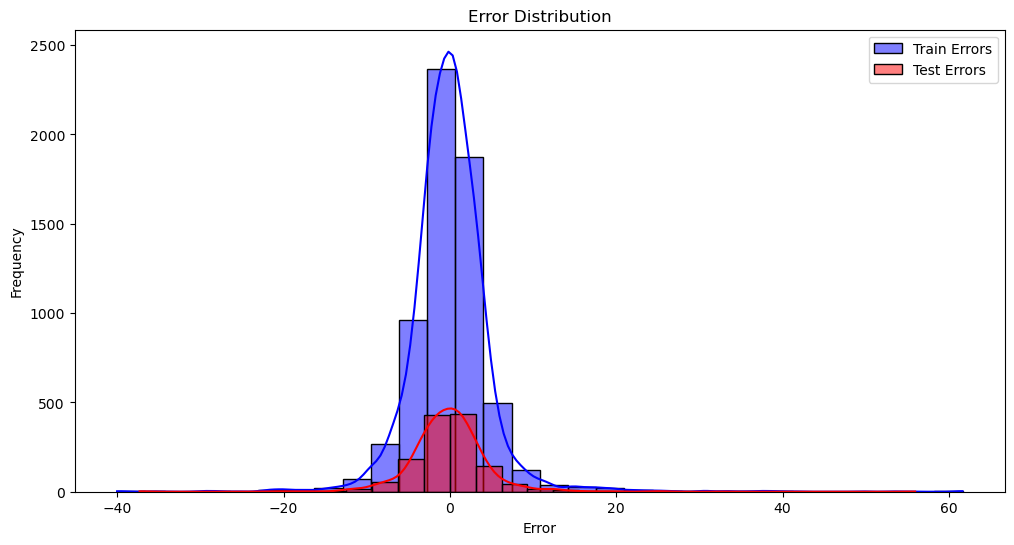

In [26]:
# Plot error distribution
train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

plt.figure(figsize=(12, 6))
sns.histplot(train_errors, bins=30, kde=True, color='blue', label='Train Errors')
sns.histplot(test_errors, bins=30, kde=True, color='red', label='Test Errors')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

RandomForest Training MSE: 1.83, R2: 0.99
RandomForest Test MSE: 12.55, R2: 0.95


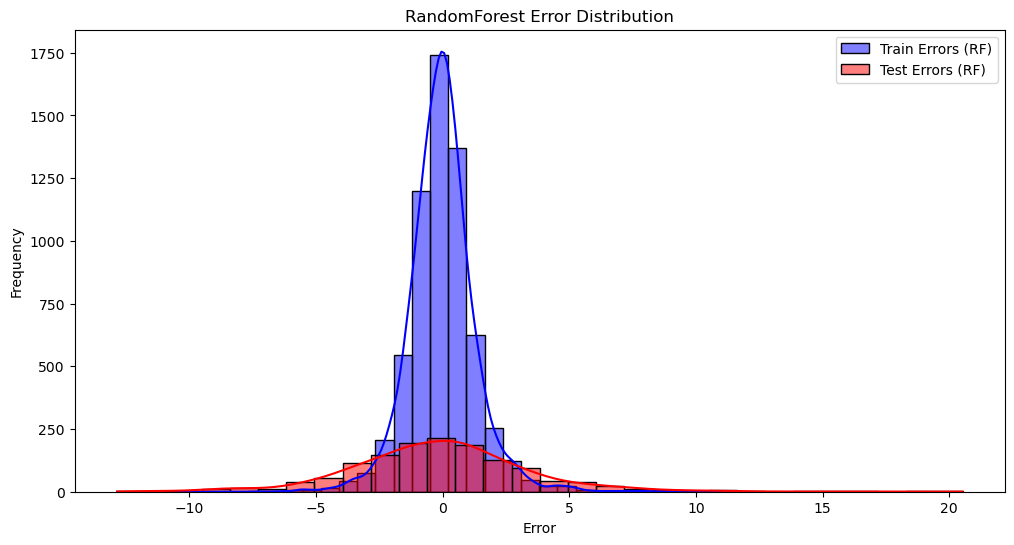

In [27]:
# Import necessary libraries for RandomForest
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42)

# Fit the model on the training data
forest_model.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred_rf = forest_model.predict(X_train)
y_test_pred_rf = forest_model.predict(X_test)

# Calculate performance metrics
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

# Print performance metrics
print(f"RandomForest Training MSE: {train_mse_rf:.2f}, R2: {train_r2_rf:.2f}")
print(f"RandomForest Test MSE: {test_mse_rf:.2f}, R2: {test_r2_rf:.2f}")

# Plot error distribution
train_errors_rf = y_train - y_train_pred_rf
test_errors_rf = y_test - y_test_pred_rf

plt.figure(figsize=(12, 6))
sns.histplot(train_errors_rf, bins=30, kde=True, color='blue', label='Train Errors (RF)')
sns.histplot(test_errors_rf, bins=30, kde=True, color='red', label='Test Errors (RF)')
plt.title('RandomForest Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The Random Forest model shows a tight error distribution around zero for both training and test sets, indicating accurate and consistent predictions.

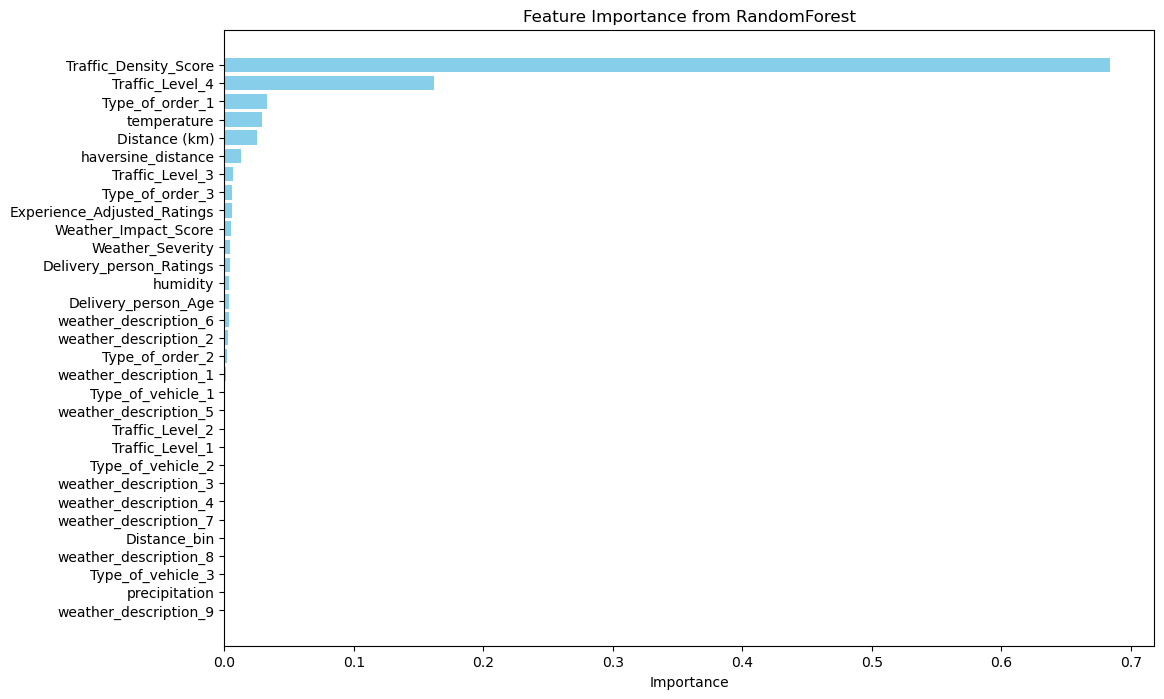

In [28]:

feature_importances = forest_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from RandomForest')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

### Feature Importance Graph
1. Top Features:
- The `Traffic_Density_Score` is the most important feature, indicating that traffic conditions significantly impact delivery times.
- `Traffic_Level_4` also shows high importance, suggesting that very high traffic levels are critical in predicting delivery efficiency.
2. Moderate Features:
- Features like `Type_of_order_1` and `temperature` have moderate importance, indicating they also play a role but are less influential than traffic-related features.
3. Less Important Features:
- Features such as `precipitation` and various `weather_description` categories have lower importance, suggesting that weather conditions might have a lesser impact compared to traffic.

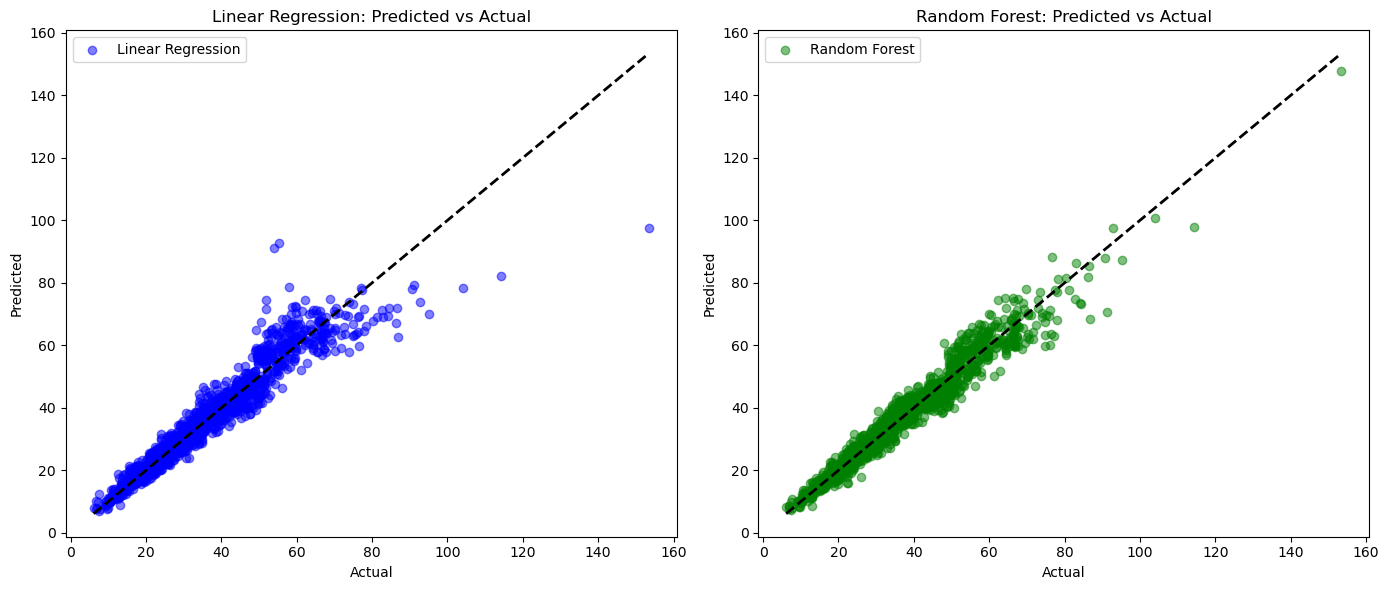

In [29]:
plt.figure(figsize=(14, 6))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Predicted vs Actual')
plt.legend()

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Predicted vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

### Predicted vs Actual Graph
1. Linear Regression:
- The predictions are generally close to the actual values, but there is more scatter, especially at higher values, indicating potential underfitting.
2. Random Forest:
- The predictions are tightly clustered around the diagonal line, showing better alignment with actual values and suggesting a more accurate model.
3. Overall Comparison:
Random Forest appears to handle the variability in the data better than Linear Regression, especially for higher target values.

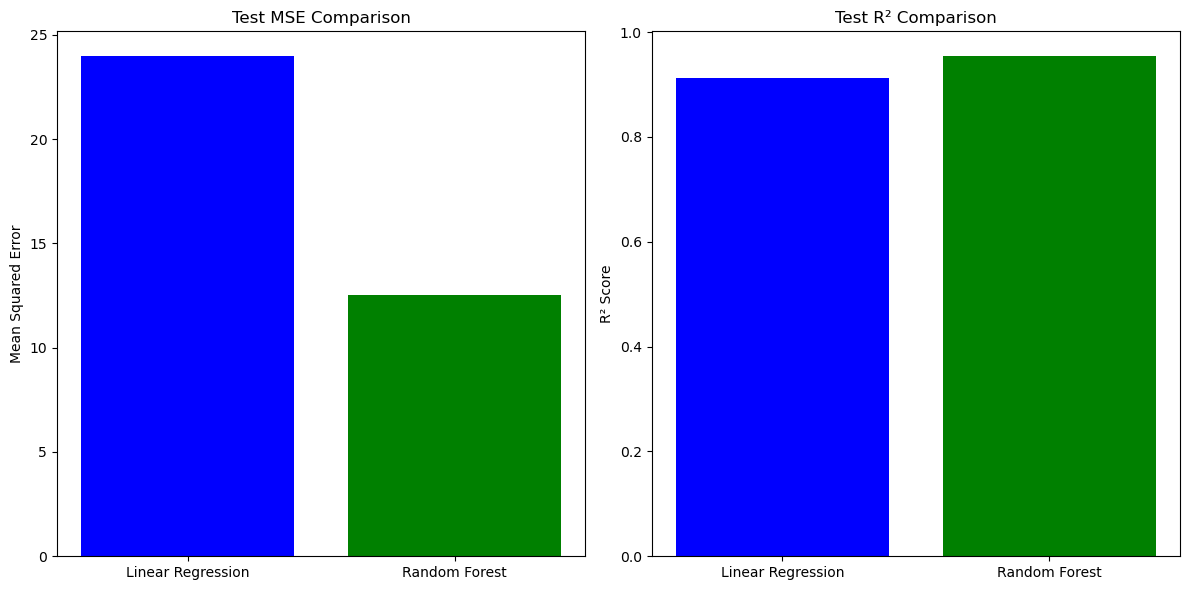

In [30]:
# Calculate performance metrics for both models
metrics = {
    'Model': ['Linear Regression', 'Random Forest'],
    'Test MSE': [test_mse, test_mse_rf],
    'Test R²': [test_r2, test_r2_rf]
}

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)

# Plot the metrics using a bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Test MSE
ax[0].bar(metrics_df['Model'], metrics_df['Test MSE'], color=['blue', 'green'])
ax[0].set_title('Test MSE Comparison')
ax[0].set_ylabel('Mean Squared Error')

# Plot Test R²
ax[1].bar(metrics_df['Model'], metrics_df['Test R²'], color=['blue', 'green'])
ax[1].set_title('Test R² Comparison')
ax[1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

### Metrics Comparison Plot
1. Mean Squared Error (MSE): Random Forest has a significantly lower MSE compared to Linear Regression, indicating it makes more accurate predictions on average.
2. R-squared (R²): Random Forest achieves a higher R² score, suggesting it explains more variance in the data compared to Linear Regression.
3. Model Performance: Overall, Random Forest outperforms Linear Regression in both metrics, making it a better choice for this dataset.

In [31]:
import joblib

# Save the RandomForest model to a file
joblib.dump(forest_model, 'random_forest_model.joblib')

['random_forest_model.joblib']